# Projection of Death Probability in the future

AIM: based on past data on `DCIS_MORTALITA1/PROBDEATH` create a model for future projection of death probability.

Note that ISTAT projections in `DCIS_PREVDEM1` do not include `PROBDEATH`: there is only `DEATHRATE` but not by age.

In [ ]:
import warnings 
import numpy as np
import pandas as pd
import requests
import matplotlib
import matplotlib.pyplot as plt
import plotly.io as pio

pio.renderers.default = 'vscode+notebook'

warnings.filterwarnings('ignore')
requests.urllib3.disable_warnings() # avoid "InsecureRequestWarning: Unverified HTTPS request is being made to host 'sdmx.istat.it'. Adding certificate verification is strongly advised"

def get_colors(n, cmap_name="rainbow"):
    """Get colors for px colors_discrete argument, given the number of colors needed, n."""
    cmap = matplotlib.colormaps[cmap_name]
    colors = [cmap(i) for i in np.linspace(0, 1, n)]  # Generate colors
    colors_str = [f"rgba({int(color[0]*250)}, {int(color[1]*250)}, {int(color[2]*250)}, 1.0)" for color in colors]
    return colors_str

In [2]:
dfdp = pd.read_csv("../data/deathprob_by_age_year.csv").set_index("age").rename(columns=int) # From Notebook 30

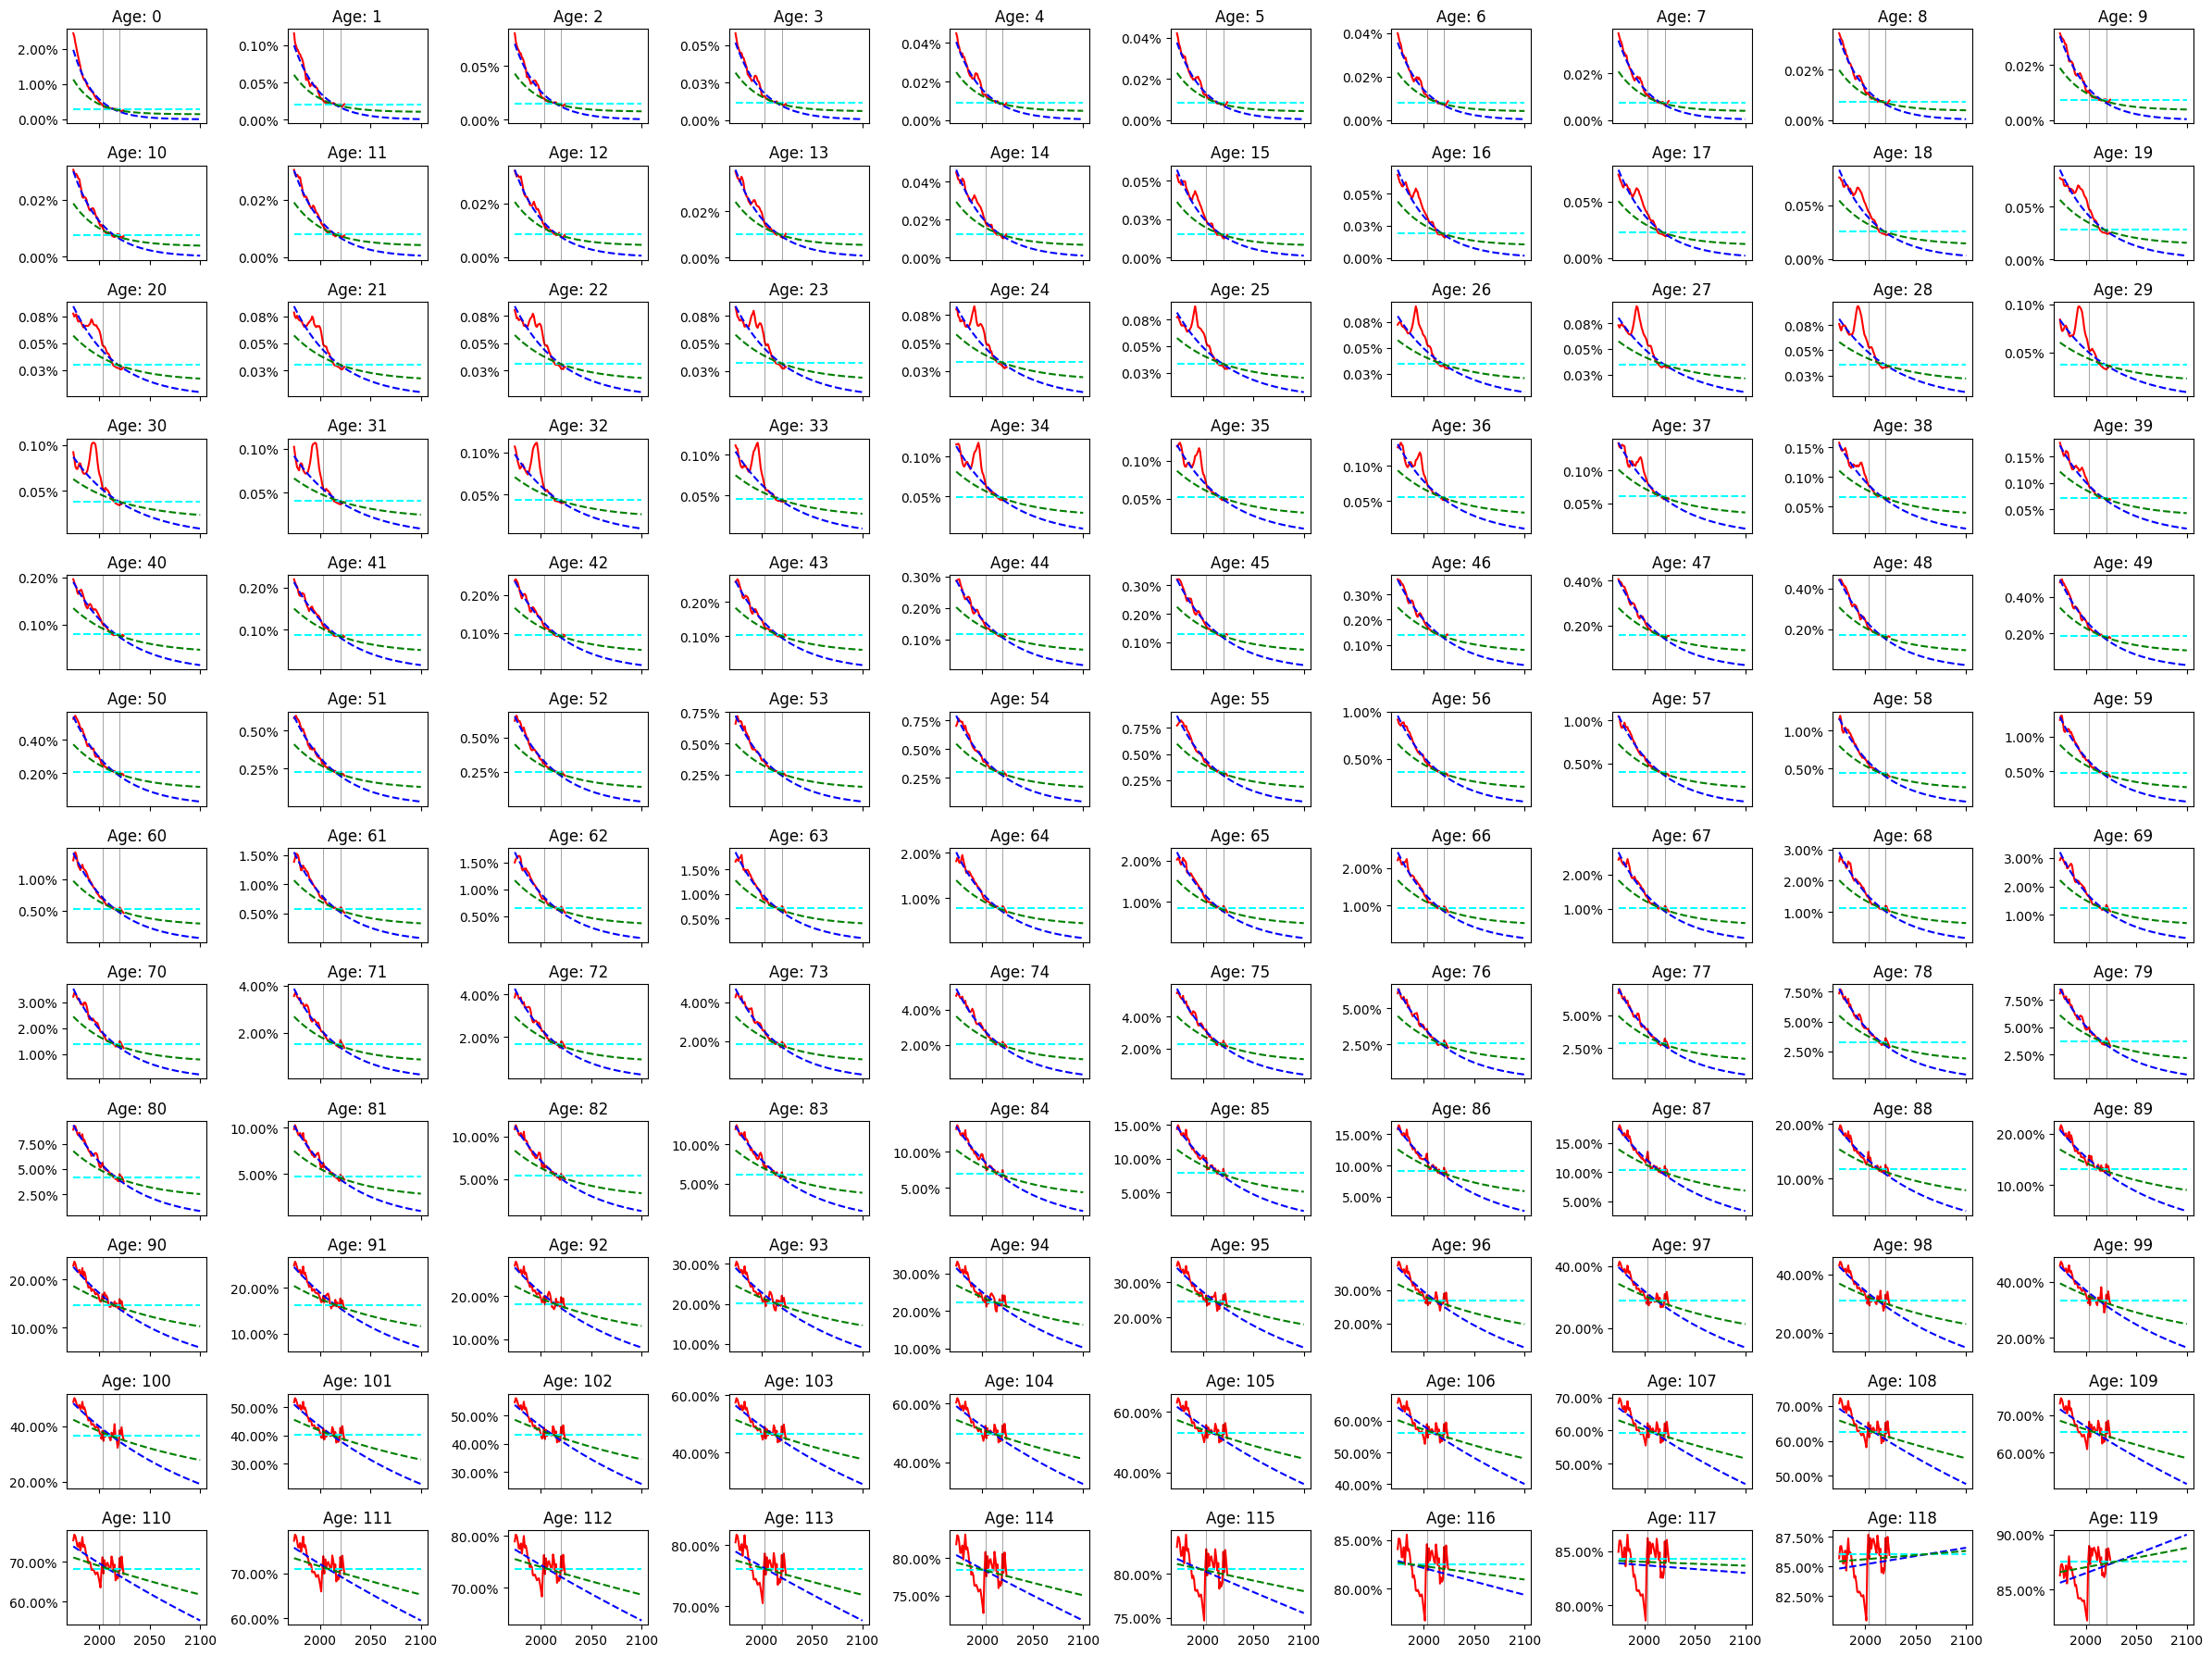

In [ ]:
start_year = dfdp.columns[0] # 2002
last_year = dfdp.columns[-1] # 2023 (or later if updated)
end_year = 2100

years_projection = list(range(start_year, end_year+1))

fit_coeff22 = {}
fit_polyn22 = {}
for age in dfdp.index:
    if 1 <= age <= 40: # remove years of possible drug-related deaths + heatwave + COVID-19
        years_excluded = list(range(1988, 1999+1)) + [2003, 2020, 2021]
        years_included = dfdp.columns.difference(years_excluded)
        fit_coeff22[age] = np.polyfit(years_included, np.log(dfdp.loc[age,years_included]), 1)
    else:
        years_excluded = [2003, 2020, 2021] # remove years of heatwave + COVID-19
        years_included = dfdp.columns.difference(years_excluded)
        fit_coeff22[age] = np.polyfit(years_included, np.log(dfdp.loc[age,years_included]), 1)
    fit_polyn22[age] = np.poly1d(fit_coeff22[age])

fig, axs = plt.subplots(12, 10, figsize=[24, 18], sharex=True)
dfdpj = pd.DataFrame(index=dfdp.index, columns=years_projection)
for iplot, age in enumerate(dfdp.index):
    ax = axs.flatten()[iplot]
    ax.plot(dfdp.columns, dfdp.loc[age] * 100, color="red")
    ax.plot(years_projection, np.exp(fit_polyn22[age](years_projection)) * 100, color="blue", linestyle="--")
    recent_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2022, 2023] # last ca. 10 years excluding COVID-19 - to improve automatically compunting 
    avg_recent = dfdp.loc[age, recent_years].mean()
    ax.plot(years_projection, avg_recent * 100 * np.ones(len(years_projection)), color="cyan", linestyle="--")
    mixed_proj = np.array([ np.mean([x, avg_recent]) for x in np.exp(fit_polyn22[age](years_projection))])
    dfdpj.loc[age] = mixed_proj
    ax.plot(years_projection, mixed_proj * 100, color="green", linestyle="--")
    ax.set_title(f"Age: {age}") 
    ax.axvline(2003, color="black", linestyle="-", lw=0.5, alpha=0.5) # heatwave - investigate in Notebook 53
    ax.axvline(2020, color="black", linestyle="-", lw=0.5, alpha=0.5) # COVID-19, also change in methodology (see Notebook 25)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))
plt.tight_layout()
# save to png
plt.savefig("../images_output/deathprob_by_age_year_projection.png", dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# save the projected death probabilities
dfdpj.loc[:, list(range(last_year+1, end_year+1))].to_csv("../data/deathprob_by_age_year_proj.csv", index=True)